In [50]:
#imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import os
import pandas as pd
from matplotlib import pyplot as plt
pd.options.display.float_format = '{:,.2f}'.format
%config InlineBackend.figure_format = 'svg'

In [3]:
from utils.basic_utils import csv_store, csv_ext, numeric_cols
from utils.pricing import dummy_col, px_fwd_ret, get_ind_index, discret_rets
from utils.pricing import rename_col
from utils.fundamental import chain_outlier
from utils.TechnicalDS import TechnicalDS

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.layers import BatchNormalization

Loading utils/config.json


Using TensorFlow backend.


In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

### Context data

In [5]:
# context
context = {
    'ml_path': '../ML/',
    'model_name': 'micro_TF.h5',
    'tmp_path': '../tmp/',
    'px_vol_ds': 'universe-px-vol-ds.h5',
    'trained_cols': 'micro_TF_train_cols.npy',
    'look_ahead': 120,
    'look_back': 252*5,
    'load_ds': True,
    'scale': True,
    'test_size': .05,
    'verbose': True,
    's3_path': 'recommend/micro_ML/',
    'units': 300, #850
    'max_iter': 10, #50
    'l2_reg': 0.01,
}

In [6]:
# get latest pricing file from inferece server
px_close_ds = context['px_vol_ds']
tmp_path = context['tmp_path']
os.makedirs(tmp_path, exist_ok=True)
!scp -i ~/.ssh/qc_infra.pem ubuntu@52.13.205.29:~/inception/tmp/{px_close_ds} {tmp_path}{px_close_ds}

universe-px-vol-ds.h5                         100%  114MB   2.4MB/s   00:47    


In [7]:
tech_ds = TechnicalDS(
    context['tmp_path'], 
    context['px_vol_ds'], 
    load_ds=True, 
    look_ahead=context['look_ahead'], 
    max_draw_on=True, 
    tickers='All',
#   tickers=None, quantile=0.75
)
y_col = tech_ds.ycol_name

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4672 entries, 2004-05-23 to 2019-05-22
Columns: 6380 entries, (high, 0700.HK) to (volume, ^VIX)
dtypes: float32(6380)
memory usage: 113.7 MB
None
Target date: 2019-05-24
Loading file quote/csv/2019-05-24
Loading file summary-categories/assetProfile
1199 companies
Sectors: 11, Industries: 136


### Final

In [8]:
def pre_process_ds(context):
    raw_df = tech_ds.stitch_companies_groups()
    print(f'Shape excluding NAs: {raw_df.shape}')
    symbols = raw_df.reset_index().set_index(['symbol']).index
    sector_map = tech_ds.profile.loc[tech_ds.tickers,'sector'].to_dict()
    raw_df.loc[:, 'sector'] = symbols.map(sector_map)
    raw_df = chain_outlier(raw_df, None)
    # basic impute and scaling
    scale_on = context['scale']
    scaler = StandardScaler()
    num_cols = numeric_cols(raw_df)
    if scale_on: raw_df.loc[:, num_cols] = scaler.fit_transform(
        raw_df[num_cols])
    # add categoricals
    raw_df.dropna(subset=['sector'], inplace=True)
    raw_df = dummy_col(raw_df, 'sector', shorten=True)
    return raw_df

In [9]:
def predict_ds(context):
    
    ml_path = context['ml_path']
    model_name = context['model_name']
    trained_cols = context['trained_cols']
    look_back = context['look_back']

    joined_df = pre_process_ds(context)
    joined_df.reset_index(level=1, inplace=True)
    pred_X = joined_df.loc[joined_df.sort_index().index.unique()[-look_back:], :]
    print('pred_X.shape', pred_X.shape)

    # ensure prediction dataset is consistent with trained model
    # save feature order
    train_cols = np.load(ml_path + trained_cols, allow_pickle=True)
    missing_cols = [x for x in train_cols if x not in pred_X.columns]
    if len(missing_cols):
        print(f'Warning missing columns: {missing_cols}')
        for c in missing_cols:
            pred_X[c] = 0

    sorted_cols = list(np.append(train_cols, ['symbol']))
    print('pred_X.shape', pred_X[sorted_cols].shape)

    pred_df = pd.DataFrame()
    pred_df['symbol'] = pred_X.symbol

    # Load model
    fname = ml_path + model_name
    model = load_model(fname)
    print('Loaded', fname)

    preds = model.predict(pred_X[sorted_cols].iloc[:, :-1])
    preds_classes = model.predict_classes(pred_X[sorted_cols].iloc[:, :-1])

    labels = tech_ds.forward_return_labels
    pred_df['pred_class'] = preds_classes
    pred_df['pred_label'] = list(map(lambda x: labels[x], preds_classes))
    probs = np.round(preds, 3)
    # higest prob
    pred_df['confidence'] = [x[np.argmax(x)] for x in probs]
    prob_df = pd.DataFrame(probs, index=pred_df.index, columns=labels)
    pred_df = pd.concat([pred_df, prob_df[labels]], axis=1)
    pred_df.index.name = 'pred_date'

    # store in S3
    s3_path = context['s3_path']
    s3_df = pred_df.reset_index(drop=False)
    rename_col(s3_df, 'index', 'pred_date')
    csv_store(s3_df, s3_path, csv_ext.format(tech_ds.tgt_date))

    return pred_df

#### Predict

In [10]:
%%time 
# predict for all
pred_df = predict_ds(context)

OCLHV dataframes
Inverting instruments
Change dataframes
Relative performance dataframes
Relative volume and dollar value dataframes
Realized volatility dataframe
Percentage change stds dataframes
Max draw/pull dataframes
Ranked returns dataframes
Forward return dataframe
Group index
Group percentage changes
Group pct stds
Group performance deltas
% above MA by group
% positive / negative chg stds by group
Group 50 day stds
Group 50 day deltas
Ranked returns dataframes
Dataset columns: Index(['PctChg1', 'PctChg20', 'PctChg50', 'PctChg200', 'IntraDayChg',
       'OpenGap', 'Pct50MA', 'Pct200MA', 'Pct52WH', 'Pct52WL', 'PctVol10DA',
       'PctVol50DA', 'PctDV10DA', 'PctDV50DA', 'RollRealVol30', 'PctChgStds1',
       'PctChgStds20', 'PctChgStds50', 'PctChgStds200', 'MaxDraw120',
       'MaxPull120', 'PerfRank20', 'PerfRank50', 'PerfRank200', 'fwdRet120',
       '50StdsAll', '50StdsSect', '50StdsInd', '200StdsAll', '200StdsSect',
       '200StdsInd', 'pctGt50MAAll', 'pctGt50MASect', 'pctGt

/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


pred_X.shape (1493100, 70)
pred_X.shape (1493100, 69)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loaded ../ML/micro_TF.h5
Saved recommend/micro_ML/2019-05-24.csv
CPU times: user 35min 31s, sys: 47min 57s, total: 1h 23min 29s
Wall time: 11min 58s


#### Visualize

In [11]:
symbol = np.random.choice(tech_ds.tickers)
clean_px, labels = tech_ds.clean_px, tech_ds.forward_return_labels
print(f'Active symbol: {symbol}\n first five elements: {tech_ds.tickers[:5]}')

Active symbol: GPC
 first five elements: ['0700.HK', '1810.HK', '3690.HK', '9984.T', 'A']


In [12]:
# recommendation distribution
print('Prediction distribution')
pd.value_counts(pred_df.pred_label) / pd.value_counts(pred_df.pred_label).sum()

Prediction distribution


bear      0.52
bull      0.30
neutral   0.15
long      0.02
short     0.01
Name: pred_label, dtype: float64

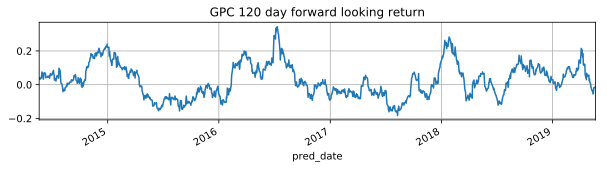

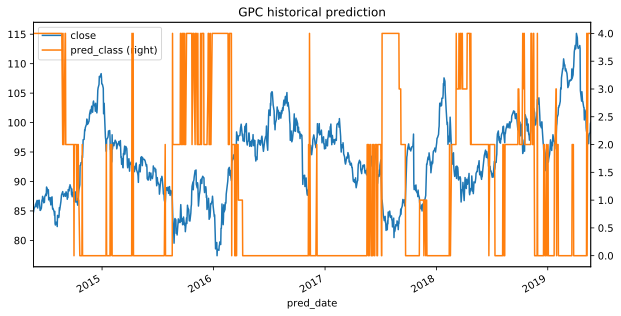

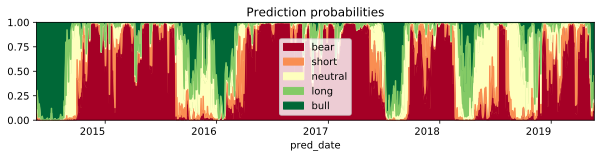

In [52]:
def plot_symbol_hist_pred(pred_symbol, clean_co_px, context, pred_df, labels):
    
    # pred_symbol = random.choice(joined_df.symbol.unique())
    pred_symbol = pred_symbol if pred_symbol is not None else random.choice(joined_df.symbol.unique())
    px_df = clean_co_px[pred_symbol]
    px_df.name = 'close'
    look_ahead = context['look_ahead']
    pct_chg_df = px_df.pct_change(look_ahead)
    pct_chg_df.name = 'pct_chg'

    co_pred = pred_df.loc[pred_df.symbol.isin([pred_symbol]), ['pred_class'] + labels]
    hist_pred = pd.concat([px_df.loc[pred_df.index.unique()], co_pred['pred_class']], axis=1, sort=False)

    # forward looking returns
    pct_chg_df.loc[pred_df.index.unique()].dropna().plot(
        title=f'{pred_symbol} {int(np.mean(context["look_ahead"]))} day forward looking return', 
        figsize=(10, 2), grid=True)

    # historical predictions
    hist_pred.dropna().plot(
        title=f'{pred_symbol} historical prediction', 
        figsize=(10, 5), secondary_y='pred_class')

    # probability distribution
    co_pred[labels].plot.area(
        title='Prediction probabilities', 
        figsize=(10, 2), ylim=(0, 1), cmap='RdYlGn', rot=0)

plot_symbol_hist_pred(symbol, clean_px, context, pred_df, labels)

In [14]:
pred_df.loc[pred_df.symbol.isin([symbol])].head()

,symbol,pred_class,pred_label,confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,
2014-05-21,GPC,4,bull,0.87,0.02,0.00,0.05,0.05,0.87
2014-05-22,GPC,4,bull,0.88,0.01,0.00,0.08,0.03,0.88
2014-05-23,GPC,4,bull,0.70,0.09,0.04,0.14,0.03,0.70
2014-05-27,GPC,4,bull,0.96,0.01,0.00,0.02,0.00,0.96
2014-05-28,GPC,4,bull,0.95,0.01,0.00,0.03,0.01,0.95


### AI driven portfolio construction (one period)

In [267]:
loss_protection = True # stop losses dont seem to help
max_loss = 0.1
long = True # enable long or short
holding_period = 20 # how many days to hold / rebalance
as_of_date = -holding_period; study_period = -30;
min_confidence = 0.8
max_class_rows = 50
nbr_positions = 50
pred_classes = [3, 4] if long else [0, 1]

In [268]:
def get_top_predictions(pred_df, as_of_date, min_confidence, max_class_rows):
    """ return top recommendatins by label as of a given date """
    label_mask = (pred_df.pred_label.isin(['bear', 'short', 'long', 'bull'])) \
        & (pred_df.confidence > min_confidence)

    top_pred = pred_df.loc[(pred_df.index == pred_df.index.unique()[as_of_date]) & label_mask]\
        .sort_values(by=['pred_label', 'confidence'], ascending=False)\
        .groupby(by='pred_label').head(max_class_rows)
    
    return top_pred
    
top_pred = get_top_predictions(pred_df, as_of_date, min_confidence, max_class_rows)

In [269]:
def get_study_date_range(pred_df, as_of_date, study_period):
    """ 
    return date range for a study period, as of = prediction, 
    study period = number of days to observe stability of predictions    
    """
    return pred_df.index.unique()[study_period + as_of_date:as_of_date]

study_dates = get_study_date_range(pred_df, as_of_date, study_period)
study_dates

DatetimeIndex(['2019-03-13', '2019-03-14', '2019-03-15', '2019-03-18',
               '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-22',
               '2019-03-25', '2019-03-26', '2019-03-27', '2019-03-28',
               '2019-03-29', '2019-04-01', '2019-04-02', '2019-04-03',
               '2019-04-04', '2019-04-05', '2019-04-08', '2019-04-09',
               '2019-04-10', '2019-04-11', '2019-04-12', '2019-04-15',
               '2019-04-16', '2019-04-17', '2019-04-18', '2019-04-22',
               '2019-04-23', '2019-04-24'],
              dtype='datetime64[ns]', name='pred_date', freq=None)

In [270]:
# historical recomendations for top predictions
def get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes, treshold=0.6):
    """ return most frequent predictions of a given class for a study period """
    # print(f'Most frequent predictions as of {study_dates[-1]} for classes {pred_classes}')
    last_xdays_pred = pred_df.loc[study_dates]
    last_xdays_pred = last_xdays_pred.loc[
        last_xdays_pred.symbol.isin(list(top_pred.symbol)), 
        ['symbol', 'pred_class', 'confidence']
    ].reset_index()
    most_freq_df = last_xdays_pred.groupby(
        by=['symbol', 'pred_class'])\
        .agg(['count', 'mean']).reset_index()
    
    return most_freq_df.loc[
        most_freq_df['pred_class'].isin(pred_classes)\
        & (most_freq_df[('confidence','count')] > int(len(study_dates) * treshold))]\
        .sort_values(by=('confidence', 'count'), ascending=False)
        
most_freq_df = get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes, 0.6)
top_pos = most_freq_df.head(nbr_positions)
symbols = list(top_pos.symbol)

print(f'{len(symbols)} Symbols: {symbols}')

28 Symbols: ['MIME', 'OLLI', 'VSM', 'CHTR', 'SRCL', 'SFM', 'FIVE', 'GDS', 'SE', 'RGEN', 'PACB', 'TTM', 'COST', 'ORCL', 'MNRO', 'SQ', 'AVAV', 'EW', 'BL', 'HAE', 'DISH', 'UNIT', 'CMC', 'WIX', 'IDXX', 'BLUE', 'IOVA', 'EA']


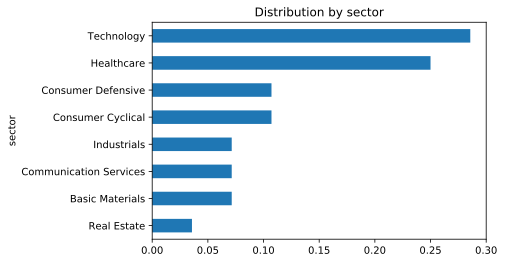

In [271]:
# Distribution by sector
by_sect = tech_ds.profile.loc[symbols].groupby(by=['sector']).count().iloc[:,0].sort_values()
(by_sect / by_sect.sum()).plot.barh(title='Distribution by sector');

In [272]:
# Distribution by industry
by_ind = tech_ds.profile.loc[symbols].groupby(by=['sector', 'industry']).count().iloc[:,0].sort_values(ascending=False)
print(by_ind.head(20))

sector                  industry                      
Technology              Software - Infrastructure         3
Healthcare              Biotechnology                     3
Communication Services  Pay TV                            2
Consumer Defensive      Discount Stores                   2
Healthcare              Diagnostics & Research            2
Technology              Electronic Gaming & Multimedia    2
Real Estate             REIT - Industrial                 1
Industrials             Waste Management                  1
                        Aerospace & Defense               1
Healthcare              Medical Instruments & Supplies    1
                        Medical Devices                   1
Technology              Software - Application            1
                        Data Storage                      1
Consumer Defensive      Grocery Stores                    1
Consumer Cyclical       Specialty Retail                  1
                        Auto Parts           

In [273]:
top_pos.sort_values(by=[('confidence', 'count'), ('confidence', 'mean')], ascending=False)

symbol pred_class confidence     
                           count mean
62    FIVE          4         30 1.00
115   OLLI          4         30 1.00
138    SFM          4         30 1.00
133   RGEN          4         30 0.98
171    VSM          4         30 0.98
121   PACB          4         30 0.97
93    MIME          4         30 0.97
137     SE          4         30 0.96
31    CHTR          4         30 0.95
64     GDS          4         30 0.93
148   SRCL          4         30 0.90
162    TTM          4         29 0.96
43    COST          4         29 0.92
120   ORCL          4         27 0.96
95    MNRO          4         27 0.95
147     SQ          4         26 0.88
11    AVAV          4         25 0.94
58      EW          4         25 0.85
17      BL          4         24 0.87
70     HAE          4         23 0.78
167   UNIT          4         22 0.88
51    DISH          4         22 0.80
173    WIX          4         21 0.90
41     CMC          4         21 0.88
75    IDXX          4         20 0.87
19    BLUE          4         20 0.67
53      EA          4         19 0.93
78    IOVA          4         19 0.82

In [274]:
def stop_loss(df, long, max_loss):
    truth_df = (df < 1 - max_loss) if long else (df > 1 + max_loss)
    pos = truth_df[truth_df == True]
    if len(pos): df.loc[pos.index[0]:] = df.loc[pos.index[0]]
    return df

idx = tech_ds.clean_px.index.get_loc(study_dates[-1])
prices = tech_ds.clean_px.iloc[idx:idx+holding_period][symbols]
port_index = get_ind_index(prices, tail=holding_period, name='PORT')

if loss_protection:
    port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
    port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return

print(f'Showing returns from {tech_ds.clean_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
print(f'Portfolio shape: {port_index.shape}')

Showing returns from DatetimeIndex(['2019-04-24', '2019-05-21'], dtype='datetime64[ns]', name='storeDate', freq=None)
Portfolio shape: (20, 29)


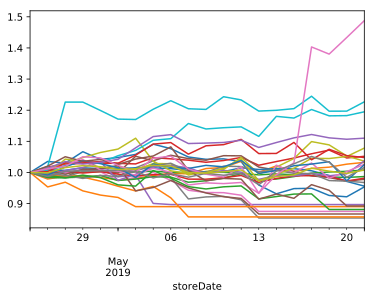

In [275]:
port_index.plot(legend=False)

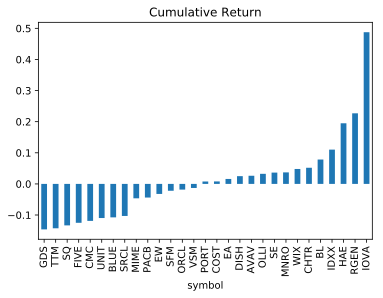

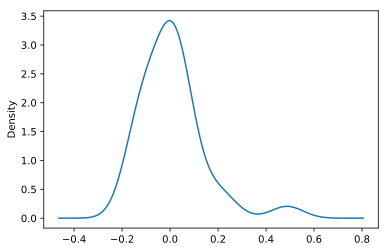

In [276]:
net_return = (port_index.iloc[-1] - 1)
net_return.sort_values().plot.bar(title='Cumulative Return'); plt.show()
net_return.plot.kde();

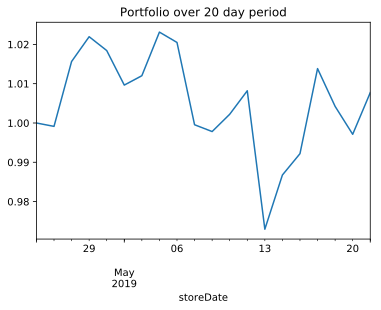

In [277]:
# cumulative returns for a given portfolio
port_index.iloc[:, -1].plot(title=f'Portfolio over {holding_period} day period')

In [278]:
# cumulative returns for a given portfolio
port_index.iloc[-1, :-1].describe()

count   28.00
mean     1.01
std      0.13
min      0.85
25%      0.90
50%      1.00
75%      1.04
max      1.49
Name: 2019-05-21 00:00:00, dtype: float64

In [279]:
print(port_index.shape)
port_index.tail()

(20, 29)


symbol,MIME,OLLI,VSM,CHTR,SRCL,SFM,FIVE,GDS,SE,RGEN,...,HAE,DISH,UNIT,CMC,WIX,IDXX,BLUE,IOVA,EA,PORT
storeDate,,,,,,,,,,,,,,,,,,,,,
2019-05-15,0.95,1.00,0.99,1.05,0.90,1.00,0.87,0.85,1.04,1.21,...,1.17,1.02,0.89,0.93,1.10,1.11,0.92,1.03,1.03,0.99
2019-05-16,0.95,1.01,0.99,1.06,0.90,0.99,0.87,0.85,1.10,1.24,...,1.20,1.03,0.89,0.93,1.04,1.12,0.96,1.40,1.05,1.01
2019-05-17,0.93,1.02,0.99,1.07,0.90,0.98,0.87,0.85,1.09,1.20,...,1.18,1.03,0.89,0.88,1.07,1.11,0.94,1.38,1.03,1.00
2019-05-20,0.92,1.03,0.98,1.05,0.90,0.97,0.87,0.85,1.05,1.20,...,1.18,0.97,0.89,0.88,1.05,1.11,0.89,1.43,0.98,1.00
2019-05-21,0.95,1.03,0.99,1.05,0.90,0.98,0.87,0.85,1.04,1.23,...,1.19,1.02,0.89,0.88,1.05,1.11,0.89,1.49,1.02,1.01


### Backtesting / historical experiments

In [421]:
# What are the best portfolios and how do they perform?

describe_list = []; symbol_list = []; pos_list = []
profile, quotes = tech_ds.profile, tech_ds.quotes

pred_period_range = range(-study_period, pred_df.index.unique().shape[0] - holding_period)
nbr_experiments = 200
random_asofs = [-x for x in np.random.choice(pred_period_range, size=nbr_experiments)]

for as_of_date in random_asofs:

    top_pred = get_top_predictions(pred_df, as_of_date, min_confidence, max_class_rows)
    study_dates = get_study_date_range(pred_df, as_of_date, study_period)
    most_freq_df = get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes, 0.6)
    top_pos = most_freq_df.head(nbr_positions)
    symbols = list(top_pos.symbol)
    
    if len(symbols) > 5:
        idx = tech_ds.clean_px.index.get_loc(study_dates[-1])
        prices = tech_ds.clean_px.iloc[idx:idx+holding_period][symbols]
        port_index = get_ind_index(prices, tail=holding_period, name='PORT')
        
        if loss_protection:
            port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
            port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return
        # print(f'Showing returns from {clean_co_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
        
        port = port_index.iloc[-1, :-1]
        exp_describe = port.describe()
        exp_describe['offset_start'] = as_of_date
        exp_describe['as_of_date'] = str(study_dates[-1])
        exp_describe['study_period'] = study_period
        exp_describe['end_date'] = str(port_index.index[-1])
        pos_list.append(port)
        symbol_list.append(symbols)
        describe_list.append(exp_describe)

position_perf = pd.concat(pos_list, axis=1).T
hist_ports = pd.concat(describe_list, axis=1).T
hist_ports = hist_ports.infer_objects()

/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [422]:
# Descriptive stats
print(f'Summary for {len(random_asofs)} experiment {"LONG" if long else "SHORT"} periods')
print(f'{len(uniq_pos_perf.index.unique())} unique symbols')

Summary for 200 experiment LONG periods
322 unique symbols


In [426]:
perf_col = f'perfAttrib{holding_period}D'
pos_attribution = position_perf.mean()
uniq_pos_perf = pos_attribution.to_frame()
uniq_pos_perf.columns = [perf_col]
uniq_pos_perf[['sector', 'industry']] = profile.loc[uniq_pos_perf.index, ['sector', 'industry']]
uniq_pos_perf['name'] = quotes.loc[uniq_pos_perf.index, ['shortName']]

In [434]:
# top ten attribution
top10_attrib = uniq_pos_perf.sort_values(by=perf_col, ascending=False).head(10)
top10_attrib

,perfAttrib20D,sector,industry,name
SIG,1.45,Consumer Cyclical,Luxury Goods,Signet Jewelers Limited
NTLA,1.38,Healthcare,Biotechnology,"Intellia Therapeutics, Inc."
NAVI,1.31,Financial Services,Credit Services,Navient Corporation
STX,1.26,Technology,Data Storage,Seagate Technology PLC
QRVO,1.24,Technology,Semiconductors,"Qorvo, Inc."
BDC,1.24,Technology,Electronic Components,Belden Inc
MGM,1.21,Consumer Cyclical,Resorts & Casinos,MGM Resorts International
FCX,1.20,Basic Materials,Copper,"Freeport-McMoRan, Inc."
BAC,1.19,Financial Services,Banks - Global,Bank of America Corporation
PLT,1.19,Technology,Communication Equipment,"Plantronics, Inc."


In [450]:
# bottom ten attribution
uniq_pos_perf.sort_values(by=perf_col, ascending=False).tail(10)

,perfAttrib20D,sector,industry,name
PTEN,0.91,Energy,Oil & Gas Drilling,"Patterson-UTI Energy, Inc."
ZBRA,0.90,Industrials,Diversified Industrials,Zebra Technologies Corporation
WPP,0.89,Consumer Cyclical,Advertising Agencies,WPP plc
INTU,0.89,Technology,Software - Application,Intuit Inc.
OAS,0.88,Energy,Oil & Gas E&P,Oasis Petroleum Inc.
MTLS,0.88,Technology,Software - Application,Materialise NV
AXE,0.87,Industrials,Industrial Distribution,Anixter International Inc.
AMG,0.87,Financial Services,Asset Management,"Affiliated Managers Group, Inc."
HP,0.86,Energy,Oil & Gas Drilling,"Helmerich & Payne, Inc."
SSYS,0.84,Technology,Computer Systems,"Stratasys, Ltd."


#### Visuals

In [468]:
perf_sector[(perf_col, 'mean')]

sector
Basic Materials          1.04
Communication Services   1.03
Consumer Cyclical        1.04
Consumer Defensive       1.03
Energy                   1.04
Financial Services       1.03
Healthcare               1.04
Industrials              1.03
Real Estate              1.03
Technology               1.04
Utilities                1.05
Name: (perfAttrib20D, mean), dtype: float32

In [457]:
perf_sector = uniq_pos_perf.groupby(by=['sector']).agg(['mean', 'count'])
perf_ind = uniq_pos_perf.groupby(by=['industry']).mean().sort_values(by=perf_col) - 1

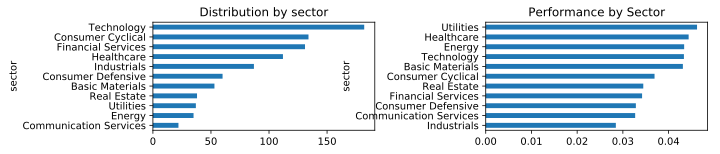

In [474]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
perf_sector[(perf_col, 'count')].sort_values().plot.barh(title='Distribution by sector', ax=axes[0]);
(perf_sector[(perf_col, 'mean')].sort_values() - 1).plot.barh(title='Performance by Sector', ax=axes[1]);

In [475]:
# Distribution by industry
by_ind = uniq_pos_perf.groupby(by=['sector', 'industry']).count().iloc[:,0].sort_values(ascending=False)
by_ind.head(20)

sector                  industry                       
Financial Services      Banks - Regional - US              53
Technology              Software - Application             43
                        Semiconductors                     26
Healthcare              Biotechnology                      22
Consumer Defensive      Packaged Foods                     20
Industrials             Business Services                  20
Communication Services  Telecom Services                   19
Healthcare              Diagnostics & Research             19
Consumer Cyclical       Specialty Retail                   19
Technology              Software - Infrastructure          18
Energy                  Oil & Gas E&P                      17
Technology              Internet Content & Information     16
Utilities               Utilities - Regulated Electric     16
Healthcare              Medical Instruments & Supplies     16
Consumer Cyclical       Leisure                            14
Technology    

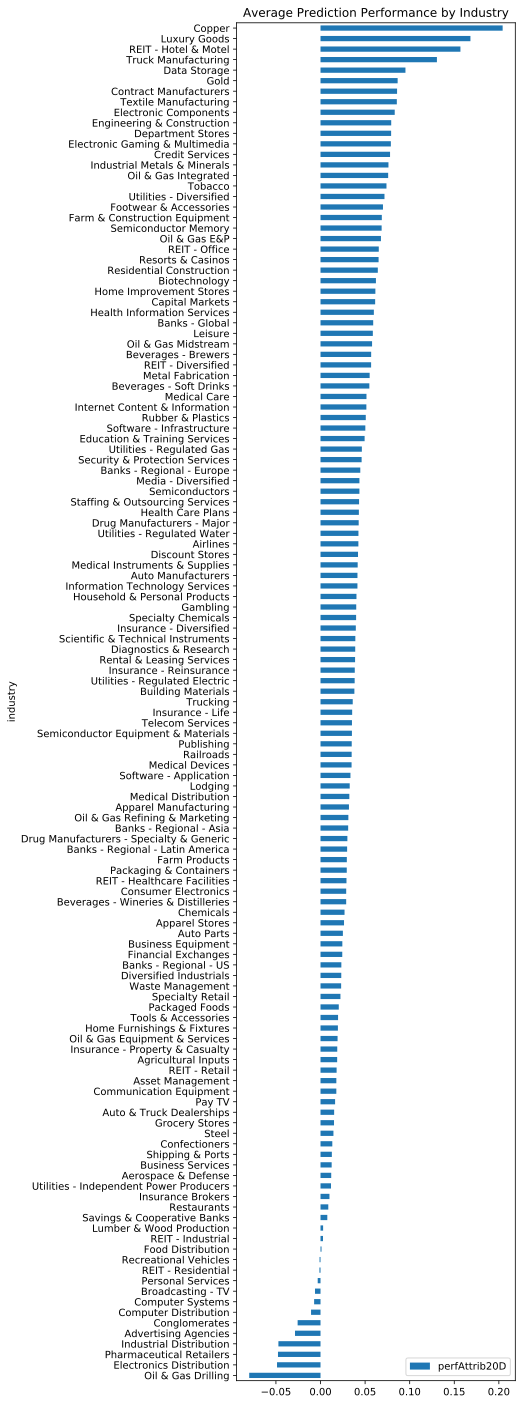

In [483]:
perf_ind.plot.barh(title='Average Prediction Performance by Industry', figsize=(5, 25));

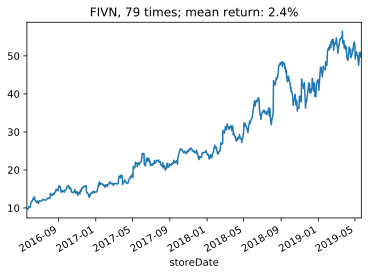

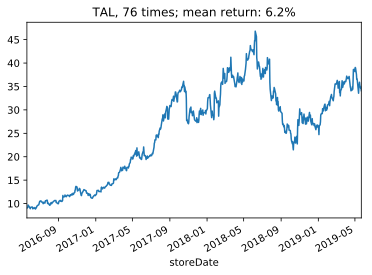

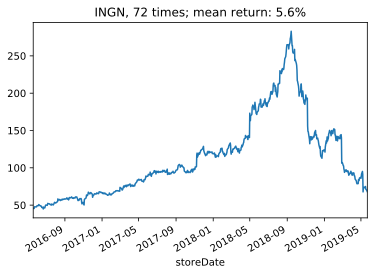

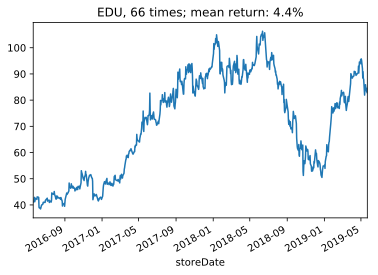

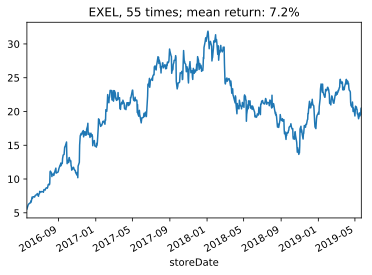

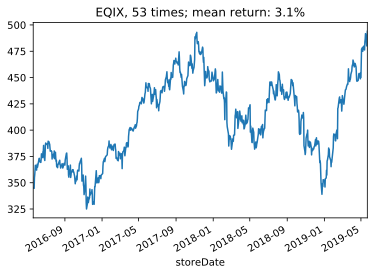

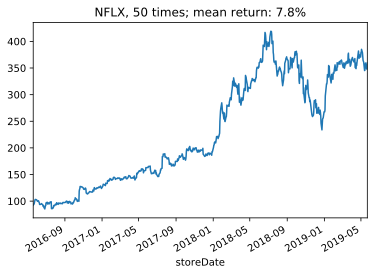

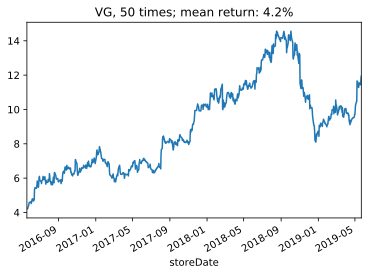

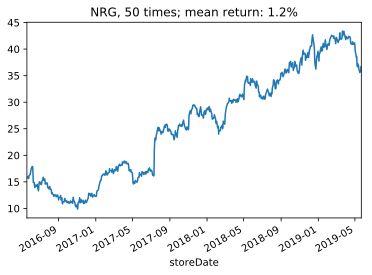

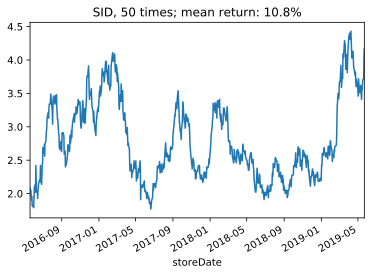

In [513]:
# Most common recommendations
most_frequent = position_perf.count(axis=0).sort_values(ascending=False).head(10)
for t in zip(most_frequent.index, most_frequent.values):
    avg_return = round((pos_attribution[t[0]]-1) * 100, 1)
    tech_ds.clean_px[t[0]].tail(252*3).plot(
        title=f'{t[0]}, {t[1]} times; mean return: {avg_return}%'); 
    plt.show()

In [138]:
mkt_cap_cuts = [0, 0.3, 2, 10, 300, 5000]
mkt_cap_labels = ['micro', 'small', 'mid', 'large', 'mega']

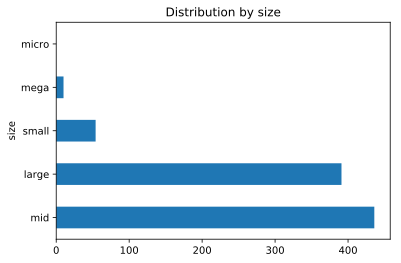

In [514]:
unique_symbols = list(uniq_pos_perf.index.unique())
size_df = tech_ds.quotes.loc[unique_symbols, ['marketCap']] / 10**9
size_df['size'] = discret_rets(size_df.marketCap, mkt_cap_cuts, mkt_cap_labels)
size_df.groupby(by=['size']).count().iloc[:,0].sort_values(ascending=False).plot.barh(title='Distribution by size');

#### Experiment results

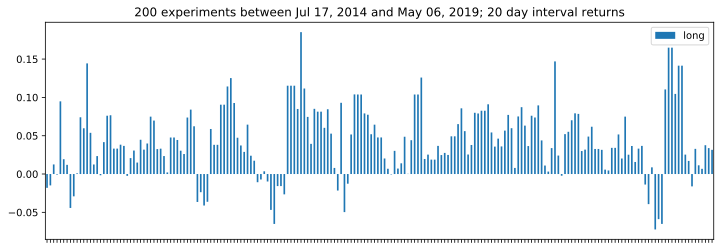

In [554]:
import datetime
monthly_rets = (mean_ret-1)
from_dt = monthly_rets.index[0].strftime('%b %d, %Y')
to_dt = monthly_rets.index[-1].strftime('%b %d, %Y')
ax = monthly_rets.plot(
    title=f'{nbr_experiments} experiments between {from_dt} and {to_dt}; {holding_period} day interval returns', 
    kind='bar', figsize=(12,4))
x_labels = monthly_rets.index.strftime('%b %y')
ax.set_xticklabels('');

count   200.00
mean      1.04
std       0.05
min       0.93
25%       1.02
50%       1.04
75%       1.07
max       1.19
Name: mean, dtype: float64

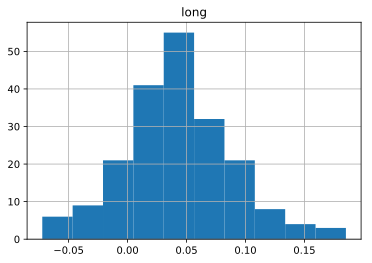

In [558]:
# Mean return distribution
monthly_rets.hist();
hist_ports['mean'].describe()

In [529]:
hist_ports.describe()

,count,mean,std,min,25%,50%,75%,max,offset_start,study_period
count,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00
mean,44.89,1.04,0.09,0.87,0.99,1.03,1.09,1.34,-655.48,-30.00
std,5.95,0.05,0.03,0.04,0.05,0.05,0.05,0.17,347.41,0.00
min,23.00,0.93,0.04,0.69,0.87,0.89,0.96,1.09,"-1,239.00",-30.00
25%,42.00,1.02,0.08,0.85,0.96,1.01,1.05,1.23,-924.25,-30.00
50%,47.00,1.04,0.09,0.87,0.99,1.03,1.08,1.30,-709.00,-30.00
75%,49.00,1.07,0.11,0.89,1.02,1.06,1.11,1.39,-339.00,-30.00
max,50.00,1.19,0.21,1.00,1.11,1.16,1.24,2.25,-31.00,-30.00


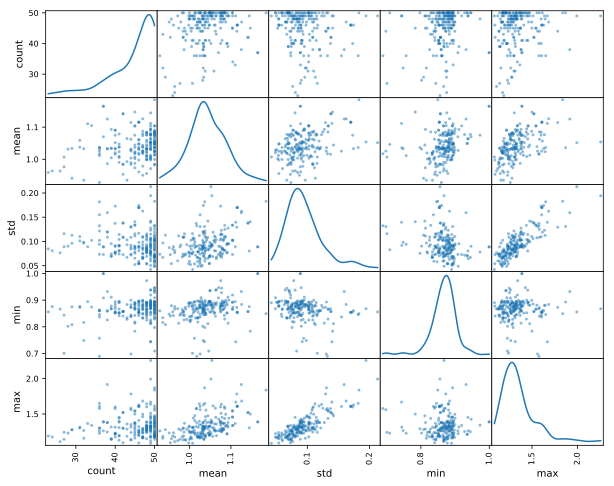

In [530]:
# relationship among position count, returns and risk
from pandas.plotting import scatter_matrix
scatter_matrix(hist_ports[['count', 'mean', 'std', 'min', 'max']], 
               diagonal='kde', figsize=(10,8));

In [533]:
# full detail for all experiments
hist_ports.sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max,offset_start,as_of_date,study_period,end_date
2018-12-24,36.00,0.93,0.07,0.86,0.88,0.90,0.96,1.26,-121.00,2018-11-26 00:00:00,-30,2018-12-24 00:00:00
2016-01-25,43.00,0.93,0.07,0.83,0.89,0.90,0.98,1.19,-856.00,2015-12-24 00:00:00,-30,2016-01-25 00:00:00
2019-01-11,32.00,0.93,0.10,0.82,0.88,0.89,1.00,1.16,-109.00,2018-12-13 00:00:00,-30,2019-01-11 00:00:00
2019-01-10,29.00,0.94,0.11,0.81,0.87,0.89,1.02,1.28,-110.00,2018-12-12 00:00:00,-30,2019-01-10 00:00:00
2016-06-27,47.00,0.95,0.09,0.85,0.89,0.92,0.98,1.23,-749.00,2016-05-31 00:00:00,-30,2016-06-27 00:00:00
2016-01-19,42.00,0.95,0.07,0.84,0.89,0.96,1.02,1.09,-860.00,2015-12-18 00:00:00,-30,2016-01-19 00:00:00
2014-10-10,48.00,0.96,0.05,0.88,0.91,0.95,0.99,1.15,"-1,179.00",2014-09-15 00:00:00,-30,2014-10-10 00:00:00
2015-09-03,23.00,0.96,0.08,0.86,0.88,0.94,1.02,1.19,-953.00,2015-08-07 00:00:00,-30,2015-09-03 00:00:00
2018-12-07,46.00,0.96,0.09,0.84,0.89,0.94,1.01,1.24,-132.00,2018-11-08 00:00:00,-30,2018-12-07 00:00:00
2015-08-26,26.00,0.96,0.08,0.87,0.89,0.97,1.02,1.11,-959.00,2015-07-30 00:00:00,-30,2015-08-26 00:00:00


### Other code

In [525]:
def calc_monthly_ret(l_w, mean_ret):
    monthly_ret = (
        (mean_ret['long'] - 1).mul(l_w) - 
        (mean_ret['short'] - 1).mul(1 - l_w) + 1)
    mix_df = monthly_ret.infer_objects().describe()
    mix_df['l'] = l_w
    mix_df['s'] = 1 - l_w
    return monthly_ret, mix_df

In [526]:
# optimal L/S mix
super_list = []
series = np.arange(0.4, 1.2, 0.05)
if 'short' in mean_ret.columns:
    for l_w in series:
        monthly_ret, mix_df = calc_monthly_ret(l_w, mean_ret)
        super_list.append(mix_df)
        monthly_ret.cumprod().plot()
    scenarios = pd.concat(super_list, axis=1).T
    opt_wgt = series[np.argmax(((scenarios['mean'] - 1) / scenarios['std']))]
    
    # expected long-term return at optimal L/S mix
    monthly_ret, _ = calc_monthly_ret(opt_wgt, mean_ret)
    print(f'Expected return = {round(monthly_ret.cumprod().iloc[-1] ** (1/years) - 1, 2)*100}% at {round(opt_wgt, 2)} long {round(1 - opt_wgt, 2)} short')
    monthly_ret.cumprod().plot();